In [1]:
# Efflux / Reflux (Cokelet & Stewart, 1985)
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import os
import glob

In [2]:
# Find the interface and vertical flux of theta
def Layer(u):
    # Layer interface, zero velocity crossing point
    uzx = u.mean(axis=(0,2)) # Z, X
    Xu = uzx.shape[1]
    itf = np.empty(Xu, dtype=int)
    itf[[0,1,-2,-1]] = 0 # Remove data at fjord head and end
    for i in range(2,Xu-2):
        l = np.where(uzx[:, i] < 0)[-1][0]
        itf[i] = l
    return itf

In [5]:
def FluxCoef(state, grid):
    state1 = state.isel(Y=range(30,39), T=range(24,161))       
    u = state1.U.data
    w = state1.W.data
    temp = state1.Temp.data
    
    Area = np.empty([50, 9]) # Cross Y direction
    Area[:10, :] = 100
    Area[10:20, :] = 200
    Area[20:30, :] = 300
    Area[30:40, :] = 800
    Area[40:, :] = 1600

    f = 55
    s = 72
    HFacW = grid.HFacW.data[:,30:39,f:s+1] # vertical fraction of open cell at West face
    rA = grid.rA.data[30:39,f:s+1] # r face area at cell center
    itf = Layer(u)
    Vx1 = np.empty(s-f+1) # Horizontal volume transport for the upper layer
    Vx2 = np.empty(s-f+1) # Horizontal volume transport for the lower layer
    Vz = np.empty(s-f+1) # Vertical volume transport through the interface
    for i in range(s-f+1):
        it = itf[f:s+1]
        ut = u[:,:,:,f:s+1].mean(0)
        wt = w[:,:,:,f:s+1].mean(0)
        Vx1[i] = np.sum(ut[:it[i],:,i] * HFacW[:it[i],:,i] * Area[:it[i],:])
        Vx2[i] = np.sum(ut[it[i]:,:,i] * HFacW[it[i]:,:,i] * Area[it[i]:,:])
        Vz[i] = np.sum(wt[it[i],:,i] * rA[:,i])
     
    Q1 = -Vx2[-1]
    Q2 = Vx1[-1]
    Q3 = -Vx2[0]
    Q4 = Vx1[0]
    alph34 = (Q3-Q1)/Q4
    alph24 = Q2 / Q4
    Qr = Q4 - Q2
    Qe = 0.5 * Q4 + 0.5 * Q1
    R_f = Q4 / 700
    return (alph34, Qr)

In [10]:

hs = np.array([9,12,15,18]) # Sill depth [8, 9, 10, 11, 12, 13, 14, 15, 16, 18, 20, 22, 30, 110, 150]
hsr = hs / 150

#a24 = np.empty(len(hs))
a34_1 = np.empty(len(hs))
Qr_1 = np.empty(len(hs))
#Q3e = np.empty(len(hs))
a34_2 = np.empty(len(hs))
Qr_2 = np.empty(len(hs))

a34_3 = np.empty(len(hs))
Qr_3 = np.empty(len(hs))

a34_4 = np.empty(len(hs))
Qr_4 = np.empty(len(hs))

for j in range(len(hs)):
    state01 = xr.open_dataset('/Users/weiyangbao/Documents/Model_outputs/qf-only-hourly/state_' + str(format(hs[j],'03d')) + '.nc')
    grid01 = xr.open_dataset('/Users/weiyangbao/Documents/Model_outputs/qf-only-hourly/grid_' + str(format(hs[j],'03d')) + '.nc')

    state02 = xr.open_dataset('/Users/weiyangbao/Documents/Model_outputs/qf-tide-hourly/state_' + str(format(hs[j],'03d')) + '.nc')
    grid02 = xr.open_dataset('/Users/weiyangbao/Documents/Model_outputs/qf-tide-hourly/grid_' + str(format(hs[j],'03d')) + '.nc')

    state03 = xr.open_dataset('/Users/weiyangbao/Documents/Model_outputs/tide006/state_' + str(format(hs[j],'03d')) + '.nc')
    grid03 = xr.open_dataset('/Users/weiyangbao/Documents/Model_outputs/tide006/grid_' + str(format(hs[j],'03d')) + '.nc')

    state04 = xr.open_dataset('/Users/weiyangbao/Documents/Model_outputs/tide01/state_' + str(format(hs[j],'03d')) + '.nc')
    grid04 = xr.open_dataset('/Users/weiyangbao/Documents/Model_outputs/tide01/grid_' + str(format(hs[j],'03d')) + '.nc')
    alph1, q1 = FluxCoef(state01,grid01)
    a34_1[j] = alph1
    Qr_1[j] = q1

    alph2, q2 = FluxCoef(state02,grid02)
    a34_2[j] = alph2
    Qr_2[j] = q2
    
    alph3, q3 = FluxCoef(state03,grid03)
    a34_3[j] = alph3
    Qr_3[j] = q3
    
    alph4, q4 = FluxCoef(state04,grid04)
    a34_4[j] = alph4
    Qr_4[j] = q4

Qr_4

array([3454.44955231, 2978.30190659, 2312.99788158, 1526.33973546])

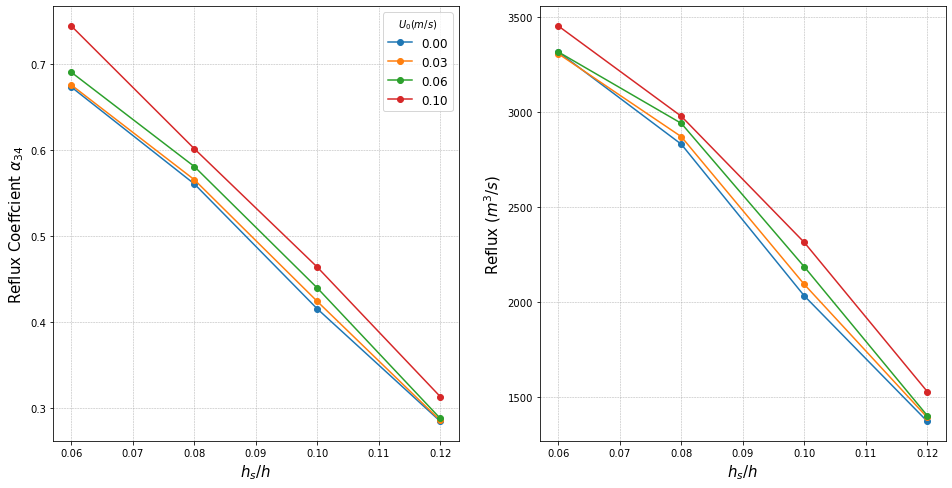

In [23]:
fig_path = "/Users/weiyangbao/Documents/Results_Figs/Transport/"
if not os.path.exists(fig_path):
    os.makedirs(fig_path)

fig1, (ax1, ax2) = plt.subplots(1,2, figsize=(16,8))

ax1.plot(hsr,a34_1,'o-',label='0.00')
ax1.plot(hsr,a34_2,'o-',label='0.03')
ax1.plot(hsr,a34_3,'o-',label='0.06')
ax1.plot(hsr,a34_4,'o-',label='0.10')
ax1.legend(loc='best', fontsize=12, title=r'$U_0(m/s)$')
ax1.set_ylabel(r'Reflux Coeffcient $\alpha_{34}$',size = 15)
ax1.set_xlabel(r'$h_s/h$', size = 15)
ax1.grid(linestyle='--', linewidth='0.5')

ax2.plot(hsr,Qr_1,'o-')
ax2.plot(hsr,Qr_2,'o-')
ax2.plot(hsr,Qr_3,'o-')
ax2.plot(hsr,Qr_4,'o-')
ax2.set_ylabel(r'Reflux $(m^3/s)$',size = 15)
ax2.set_xlabel(r'$h_s/h$', size = 15)
ax2.grid(linestyle='--', linewidth='0.5')

fig.savefig(fig_path + '/alpha34.png', dpi = 200, bbox_inches='tight')

In [18]:
def IFA(file):
    # Grid areas
    Area = np.empty([50, 9])
    Area[:10,:] = 100
    Area[10:20,:] = 200
    Area[20:30,:] = 300
    Area[30:40,:] = 800
    Area[40:,:] = 1600
    t0 = 24
    tn = 161
    state = file.isel(Y=range(30,39), T=range(t0,tn))
    MR = state.icefrntA.isel(X=1).data.mean(0) # Melt rate at the icefront
    Qsm = (MR*Area).sum()/(24*3600)
    return Qsm

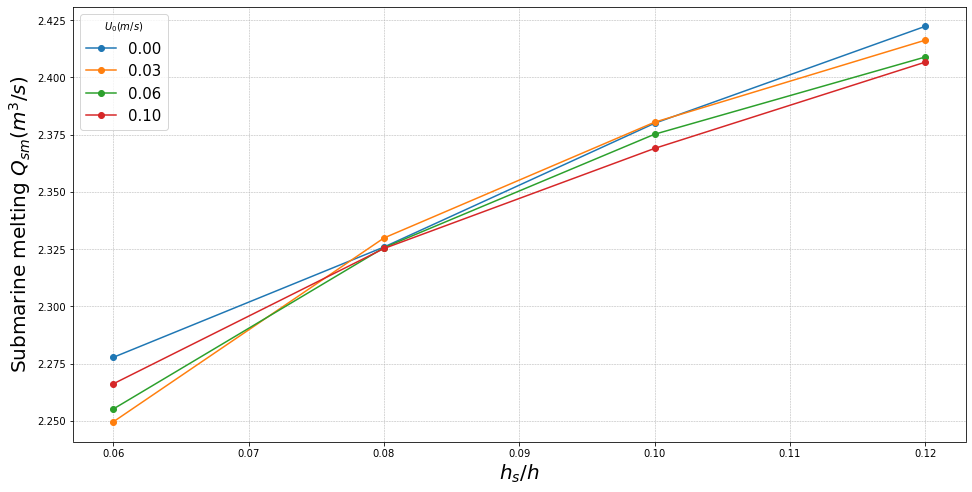

In [24]:
Qsm1 = np.empty(len(hs))
Qsm2 = np.empty(len(hs))
Qsm3 = np.empty(len(hs))
Qsm4 = np.empty(len(hs))

for j in range(len(hs)):
    file01 = xr.open_dataset('/Users/weiyangbao/Documents/Model_outputs/qf-only-hourly/icefrntA_' + str(format(hs[j],'03d')) + '.nc')
    file02 = xr.open_dataset('/Users/weiyangbao/Documents/Model_outputs/qf-tide-hourly/icefrntA_' + str(format(hs[j],'03d')) + '.nc')
    file03 = xr.open_dataset('/Users/weiyangbao/Documents/Model_outputs/tide006/icefrntA_' + str(format(hs[j],'03d')) + '.nc')
    file04 = xr.open_dataset('/Users/weiyangbao/Documents/Model_outputs/tide01/icefrntA_' + str(format(hs[j],'03d')) + '.nc')
    
    qsm1 = IFA(file01)
    Qsm1[j] = qsm1
    
    qsm2 = IFA(file02)
    Qsm2[j] = qsm2
    
    qsm3 = IFA(file03)
    Qsm3[j] = qsm3
    
    qsm4 = IFA(file04)
    Qsm4[j] = qsm4
    

fig2,ax = plt.subplots(figsize=(16,8))

ax.plot(hsr,Qsm1,'o-',label='0.00')
ax.plot(hsr,Qsm2,'o-',label='0.03')
ax.plot(hsr,Qsm3,'o-',label='0.06')
ax.plot(hsr,Qsm4,'o-',label='0.10')
ax.legend(loc='best', fontsize=15, title=r'$U_0(m/s)$')
ax.set_ylabel(r'Submarine melting $Q_{sm}(m^3/s)$',size = 20)
ax.set_xlabel(r'$h_s/h$', size = 20)
ax.grid(linestyle='--', linewidth='0.5')
fig2.savefig(fig_path + '/Qsm.png', dpi = 200, bbox_inches='tight')